In [1]:
from functools import partial
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as c
import sympy as sp
import scipy.optimize as op
from matplotlib import image

In [2]:
#Parameters 
b = 10
p = 0.5
a0= 0.01
W0 = 1
q0 = 0.005
zb = 10
hs = 0.1
hf = 0.2
rs = r = 0.5
rf = 0.5
ls = 0.5
lf = 0.2

In [3]:
maxl = 0.05
minl = 0.1
pl =10
zt = 2

In [4]:
z = zb

#Defining function:
def a(z,zm):
    a = 2*a0 * np.exp(b*(z-zm))/(1+np.exp(b*(z-zm)) )
    return(a)

def Nu(z):
    Nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return Nu

def n(z, zm, S,F,Sm):
    res = Nu(z)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def nf(z, zm, S,F,Sm):
    res = Nu(0)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def nm(zm, z, S,F,Sm):
    res = Nu(zm)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def q(z):
    q = q0* np.exp(p*z)
    return q

def W(z):
    W = W0*np.exp(w*z)- W0
    return W

def f(pop,t,z,zm):
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  rs*S*n(z,zm,S,F,Sm)/(n(z,zm,S,F,Sm) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,0)*F+W(z)) -  Ls(z) *S
    f1 =  rf*F*nf(z,zm,S,F,Sm)/(nf(z,zm,S,F,Sm) + hf)* 1/(1+ a(0,0)*F+W(0)) - Lf(0) *F
    f2= rs*Sm*nm(zm,z,S,F,Sm)/(nm(zm,z,S,F,Sm) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm) *Sm
    f = [f0, f1,f2]
    return f


In [5]:
time = np.linspace(0, 8000, 100)

In [6]:
def nm2(zm, z, S,F,Sm, Nu0, u):
    res = Nu2(zm,Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def n2(z, zm, S,F,Sm, Nu0, u):
    res = Nu2(z, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def nf2(z, zm, S,F,Sm,Nu0, u):
    res = Nu2(0, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(0)*F)
    return res

def Nu2(z,Nu0, u):
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def f2(pop,t,z,zm,Nu0,u):
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  r*S*n2(z,zm,S,F,Sm, Nu0, u)/(n2(z,zm,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,0)*F+W(z)) - Ls(z) *S
    f1 =  r*F*nf2(z,zm,S,F,Sm, Nu0, u)/(nf2(z,zm,S,F,Sm, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0)*F
    f2= r*Sm*nm2(zm,z,S,F,Sm, Nu0, u)/(nm2(zm,z,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm)*Sm
    f = [f0, f1,f2]
    return f

def Feq(Nu0, u):
    NU = Nu2(0,Nu0, u)
    A =lf*q0*hf*a0/NU
    B = lf*(a0 + hf*a0/NU+ hf*q0/NU)
    C = lf+ l*hf/NU - r

    Fe = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
    return Fe


In [7]:
def ns(z, S,F, Nu0, u):
    res = Nu2(z, Nu0, u)/(1 + q(z)*S + q(0)*F)
    return res

def nf1(z, S,F,Nu0, u):
    res = Nu2(0, Nu0, u)/(1 + q(z)*S + q(0)*F)
    return res

def Nu2(z,Nu0, u):
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def F2(POP,z, Nu0, u):
    S = POP[0]
    F = POP[1]
    f0 =  rs*S*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z) *S
    f1 =  rf*F*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0) *F
    f = [f0, f1]
    return f

def jacF2(z, S,F, Nu0, u):
    a1 = -rs*Nu(z)*S*( ( hs*q(z)*( 1 + a0*S +a(z,0)*F +W(z)) + a0*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  ) + r*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z)
    b1 = -rs*Nu(z)*S*( ( hs*q(0)*( 1 + a0*S +a(z,0)*F +W(z)) + a(z,0)*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  )
    d1 = -rf*Nu(0)*F*( ( hf*q(0)*( 1 + a0*F ) + a0*(Nu(0)+ hf*(1+ q(0)*F +q(z) *S))) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  ) + r*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0)
    c1 = -rf*Nu(0)*F*( ( hf*q(z)*( 1 + a0*F ) ) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  )
    
    jac = np.array([[a1,b1], [c1,d1]])
     
    return jac 


def Ls(z) : 
    res = maxl -(maxl-minl)*zt**pl/(z**pl + zt**pl)
    return res

def Lf(z) : 
    res = minl -(minl-maxl)*zt**pl/(z**pl + zt**pl)
    return res

In [14]:
Nu_val = np.linspace(0.5,100,100)
u_val = np.linspace(0.1,10,300)
zm_val = np.linspace(0,zb,300)
X, Y = np.meshgrid(Nu_val, u_val)

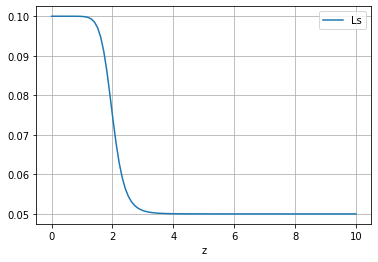

In [8]:
plt.plot(zm_val, Ls(zm_val), label='Ls')
plt.grid()
plt.xlabel('z')
plt.legend()

/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in square
/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract


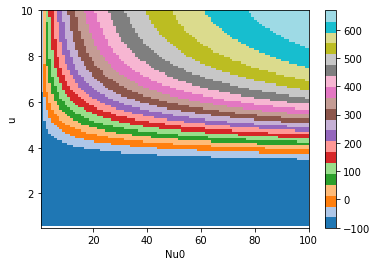

In [9]:
Z = Feq(X, Y)

plt.pcolor(X, Y, Z, cmap='tab20')
plt.xlabel('Nu0')
plt.ylabel('u')
plt.colorbar()
plt.show()

In [439]:
z=2
traj = odeint(partial(f2, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [100, 100, 0], t=time)

In [28]:
Nu0=10
b = 10
w=0.3
zm=5

In [29]:
popF = np.eye(300) 
popS = np.eye(300) 

for i in range(300):
    u = u_val[i]
    F= S = 100
    for j in range(300): 
        z= zm_val[j]
        traj = odeint(partial(f2, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [S+0.1, F+0.1, 0], t=time)
        S =  traj[-1,0] 
        F = traj[-1,1]
        popS[j,i] = S
        popF[j,i] = F

In [30]:
popF2 = np.eye(300) 
popS2 = np.eye(300) 

for i in range(300):
    u = u_val[i]
    F= S = 100
    for j in range(300): 
        z = zm_val[299-j]  
        traj = odeint(partial(f2, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [S+0.1, F+0.1, 0], t=time)
        S =  traj[-1,0]
        F = traj[-1,1]
        popS2[299-j,i] = S
        popF2[299-j,i] = F

In [31]:
coex = np.eye(300)
for i in range(300):
    for j in range(300): 
            if popF[i,j] > 1:
                if popS[i,j] > 1:
                    coex[i,j] =4 
                else:
                    coex[i,j] = 1
            else:
                if popS[i,j] > 1:
                    coex[i,j] = 2
                else:
                    coex[i,j] = 0

In [32]:
for i in range(300):
    for j in range(300): 
            if (popF[i,j] > 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] > 1) or (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] > 1) : 
                coex[i,j] = 5
            elif (popF[i,j] > 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] < 1) or  (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] < 1) : 
                coex[i,j] = 3

In [62]:
uval2 = np.linspace(0.1,10,20)

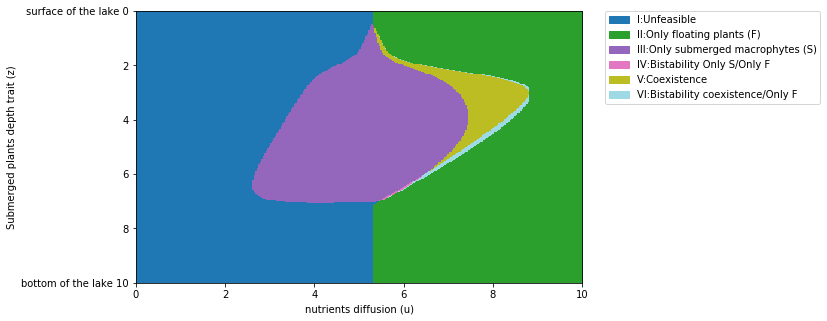

In [33]:
# get the colors of the values, according to the 
# colormap used by imshow
import matplotlib.patches as mpatches
# colormap used by imshow
plt.figure(figsize=(8,5))
im = plt.imshow(coex,cmap='tab20',extent =[0, 10, 10,0],aspect='auto')
values = np.unique(coex.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
labels = ['I:Unfeasible', 'II:Only floating plants (F)', 'III:Only submerged macrophytes (S)','IV:Bistability Only S/Only F', 'V:Coexistence', 'VI:Bistability coexistence/Only F']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
first_legend= plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )



plt.xlabel('nutrients diffusion (u)')
plt.yticks([0,2,4,6,8,10], ['surface of the lake 0',2,4,6,8,'bottom of the lake 10'], color='black')
plt.ylabel('Submerged plants depth trait (z)')

plt.show()

In [34]:
w

0.3

In [ ]:
plt.gca().add_artist(first_legend)
a1,=plt.plot(u_blanc[:79], sing_blanc[:79], c='brown', linewidth = 3, label='CSS')
a2,=plt.plot(u_red, sing_red, c='orange', linewidth = 3, label='BP')
a3,= plt.plot(u_black, sing_black, c='black',  linewidth = 3, label='Repellor')
second_legend =plt.legend(handles=[a1, a2, a3], bbox_to_anchor=(0.74, 1), loc=2, borderaxespad=14. )
plt.plot(u_blanc[145:], sing_blanc[145:], c='brown',  linewidth = 3)


plt.gca().add_artist(second_legend)
line2, = plt.plot(np.linspace(0.1,10,100), trait_mean, c='r', linewidth=2, label= 'mean trait')
p1 = plt.fill_between(np.linspace(0.1,10,1000)[np.where(trait_min > 0)], trait_max[np.where(trait_min > 0)],
       trait_min[np.where(trait_min > 0)], edgecolor='r',label= 'range of traits', facecolor = 'none',hatch="++", alpha=0.25)

plt.legend(handles=[line2, p1],bbox_to_anchor=(0.83, 1), loc=2, borderaxespad=10. )


In [38]:
u_blanc = u_val[np.where(stra == 4)]
sing_blanc = singP[np.where(stra == 4)]

u_red = u_val[np.where(stra== 3)]
sing_red = singP[np.where(stra == 3)]

u_black = u_val[np.where(stra2 == 0)]
sing_black = singP2[np.where(stra2 == 0)]

In [21]:
coex[:,752:][np.where(coex[:,753:] ==2)] = 3

In [45]:
trait_min= np.genfromtxt(fname='trait min w=0.1 hill')
trait_max= np.genfromtxt(fname='trait max w=0.1 hill')
trait_mean = np.genfromtxt(fname='trait mean w=0.1 hill')

In [46]:
trait_min[:30] = trait_max[:30] = np.repeat(trait_mean[:3],10)

In [23]:
trait_mincoevo= np.genfromtxt(fname='trait min coevo w=0.1 hill')
trait_maxcoevo= np.genfromtxt(fname='trait max coevo w=0.1 hill')
trait_meancoevo = np.genfromtxt(fname='trait mean coevo w=0.1 hill')

NameError: name 'uval2' is not defined

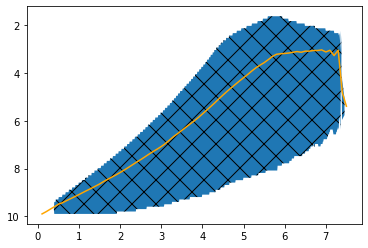

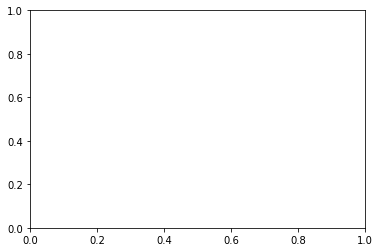

In [45]:
fig1, ax = plt.subplots(1,1)
ax.plot(np.linspace(0.1,10,100), trait_mean, c='orange')
ax.fill_between(np.linspace(0.1,10,1000)[np.where(trait_min > 0)], trait_max[np.where(trait_min > 0)], trait_min[np.where(trait_min > 0)],hatch='X')
ax.invert_yaxis()

fig2, ax2 = plt.subplots(1,1)
ax2.plot(uval2, meancoevo, c='g')
ax2.fill_between(uval2, maxcoevo,mincoevo, color='palegoldenrod')
ax2.invert_yaxis()

In [18]:
maxcoevo = np.append(trait_maxcoevo[np.where(trait_mincoevo > 0)],6.36)

In [19]:
uval2 = np.append(uval2 , 7.5)

In [20]:
meancoevo = np.append(meancoevo,3.2)
mincoevo = np.append(mincoevo,2.4)
maxcoevo = np.append(maxcoevo,6)

Text(0, 0.5, 'S pop size')

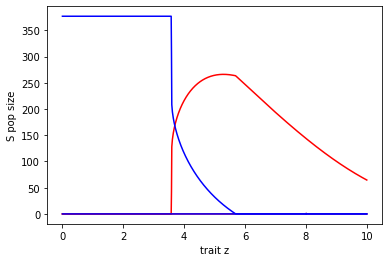

In [123]:
i = 800
plt.plot(zm_val, popS[:,i], 'r')
plt.plot(zm_val, popS2[:,i],'r')

plt.plot(zm_val, popF[:,i], 'b')
plt.plot(zm_val, popF2[:,i],'b')


plt.xlabel('trait z')
plt.ylabel('S pop size')

In [ ]:
np.savetxt('colors.txt',colors)

In [353]:
finalpopS = np.zeros(100)
finalpopF = np.zeros(100)
for i in range(100) : 
    z = singP[i] 
    k = int(z*10)
    finalpopS[i] = popS[k,i]
    finalpopF[i] = popF[k,i]

In [74]:

popFpde =np.genfromtxt(fname='pop F PDE w=0.1 hill')

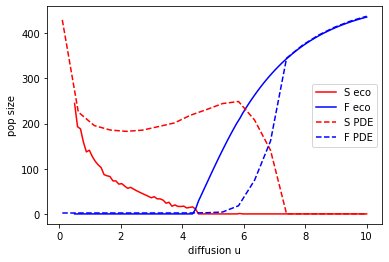

In [355]:
plt.plot(u_val, finalpopS, c='r',label='S eco' )
plt.plot(u_val, finalpopF, c='b',label='F eco' )
plt.plot(uval2, popSpde, 'r--', label='S PDE')
plt.plot(uval2, popFpde, 'b--', label='F PDE')
plt.xlabel('diffusion u')
plt.ylabel('pop size')
plt.legend()

In [14]:
trait_mean = np.genfromtxt(fname='trait mean w=0.1 hill')
trait_std = np.genfromtxt(fname='trait std w=0.1 hill')

In [10]:
coex=  np.genfromtxt(fname='w=0.2Ls hill.txt')
popS2 = np.genfromtxt(fname='popS2 w=0.2Ls hill.txt')
popS = np.genfromtxt(fname='popS w=0.2Ls hill.txt')
popF2 = np.genfromtxt(fname='popF2 w=0.2Ls hill.txt')
popF = np.genfromtxt(fname='popF w=0.2Ls hill.txt')

In [45]:
np.savetxt('w='+ valw + 'Ls hill.txt', coex)
np.savetxt('popS2 w='+ valw + 'Ls hill.txt', popS2)
np.savetxt('popS w='+ valw + 'Ls hill.txt', popS)
np.savetxt('popF2 w='+ valw + 'Ls hill.txt', popF2)
np.savetxt('popF w='+ valw + 'Ls hill.txt', popF)

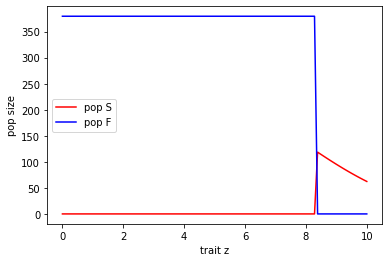

In [53]:
plt.plot(zm_val, popS2[:,79], label='pop S', c='r')
plt.plot(zm_val, popF2[:,79], label='pop F', c='b')
plt.xlabel('trait z')
plt.ylabel('pop size')
plt.legend()

In [407]:
traj = odeint(partial(f2, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [100, 100, 0], t=time)

In [408]:
A, B = np.meshgrid(zm_val, u_val)

Text(1, 1, 'unfeasble')

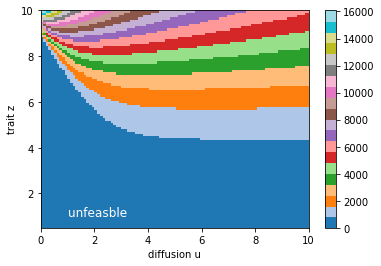

In [409]:
plt.pcolor(A, B,SS, cmap='tab20')
plt.colorbar()
plt.ylabel('trait z')
plt.xlabel('diffusion u')
plt.text(1,1, 'unfeasble', color='white', size=12)

In [27]:
def taux_fm(zf, z, F,S):
    taux = r*nm(zm,z,S,0,F)/(nm(zf,z,S,0,F) +hf)* 1/(1+ a(zf,z)*S+ a(zf,0)*F+W(zf)) - Lf(zf)
    return taux

def GradF(zm,z):
    j = np.where(u_val >= u)[0][0]
    i = np.where(zm_val >= z)[0][0] 
    S = SS[i,j]
    F = FF[i,j] 
    der = (taux_sm(zm+H,z,F,S) - taux_sm(zm,z,F,S))/H
    return der

In [28]:
from scipy.misc import derivative

In [29]:
H = 1e-6
def taux_sm(zm, z, F,S):
    taux = r*nm(zm,z,S,F,0)/(nm(zm,z,S,F,0) +hs)* 1/(1+ a(zm,z)*S+ a(zm,0)*F+W(zm)) - ls
    return taux

def GradF(zm,z):
    j = np.where(u_val >= u)[0][0]
    k = np.where(zm_val >= z)[0][0]
    if popS[i,j] > 10 : 
        S = popS[k,j]
        F = popF[k,j] 
        der = derivative(partial(taux_sm, z=z, F=F, S=S), zm, dx=10e-6)
    else : 
        S = popS2[k,j]
        F = popF2[k,j] 
        der = derivative(partial(taux_sm, z=z, F=F, S=S), zm, dx=10e-6)
            
    return der

In [30]:
def GradF2(z,zm):
    j = np.where(u_val >= u)[0][0]
    k = np.where(zm_val >= z)[0][0]
    if coex[k,j] ==5 or coex[k,j] == 3 : 
        if popS2[i,j] > 1 : 
            S = popS2[k,j]
            F = popS2[k,j] 
            der = (taux_sm(zm+H,z,F,S) - taux_sm(zm,z,F,S))/H
        else : 
            S = popS[k,j]
            F = popS[k,j] 
            der = (taux_sm(zm+H,z,F,S) - taux_sm(zm,z,F,S))/H
    else: 
        S = SS[k,j]
        F = FF[k,j]
        der = (taux_sm(zm+H,z,F,S) - taux_sm(zm,z,F,S))/H
    return der

In [31]:
def dzdzm(zm,z):
    der = derivative(partial(dz, z=z), zm, dx=10e-6)
    return der

def dzmdzm(zm,z):
    der = (GradF(zm+H,z) - GradF(zm,z))/H
    return der

def dz(zm,z):
    der = (taux_sm(zm,z+H,F,S) - taux_sm(zm,z,F,S))/H
    return der

def dzdz(zm,z):
    der2 = (dz(zm,z+H) - dz(zm,z))/H
    return der2

def dzmdz(zm,z):
    der = (GradF(zm,z+H) - GradF(zm,z))/H
    return der

In [32]:
def dicho(f, a, b, eps=1e-8):
    if f(a)*f(b) > 0 : 
        return 0  
    else :
        while abs(b-a) > eps:    
            c = (a+b)/2
            if f(a)*f(c) >= 0:
                a=c
            else:
                b=c
        return b  

def grad(z):
    return GradF(z,z)

def grad2(z):
    return GradF2(z,z)

In [33]:
def sol(fonction) : 
    sol = 0
    for i in range(99) : 
        x = zm_val[i]
        x2 = zm_val[i+1]
        val = fonction(x) 
        val2 = fonction(x2) 
        if  val*val2 < 0: 
            sol = x2
    return sol       

In [34]:
singP = np.zeros(1000)

for i in range(530):
    u = u_val[i]
    sing = dicho(grad,0.3,10)
    singP[i]= sing

for i in range(530,1000):
    u = u_val[i]
    sing = dicho(grad,1.5,10)
    singP[i]= sing

In [35]:
singP2 = np.zeros(1000)

for i in range(450):
    u = u_val[i]
    sing = dicho(grad,0,10)
    singP2[i]= sing

    
for i in range(449,1000):
    u = u_val[i]
    sing = dicho(grad,0,1)
    singP2[i]= sing
  

In [36]:
stra= np.zeros(1000)
for n in range(1000) : 
    u = u_val[n]
    z = singP[n] 
    ess = dzmdzm(z, z)
    css  = dzmdz(z,z)
    if ess < 0 : 
        if css <=0 : 
            stra[n] = 4
        else : 
            stra[n] = 1
    elif css < 0 : 
        stra[n] = 3

In [37]:
stra2= np.zeros(1000)
for n in range(1000) : 
    u = u_val[n]
    z = singP2[n] 
    ess = dzmdzm(z, z)
    css  = dzmdz(z,z)
    if ess < 0 : 
        if css <0 : 
            stra2[n] = 4
        else : 
            stra2[n] = 1
    elif css < 0 : 
        stra2[n] = 3

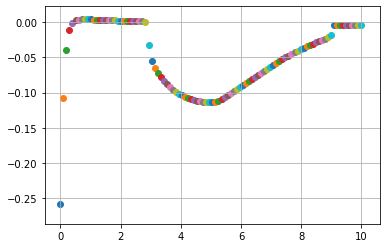

In [75]:
u=7
for i in range(100) :
    z = zm_val[i]
    to = GradF(z, z)
    plt.scatter(z,to)
plt.grid()

In [72]:
singP[69]

3.0303030340000987

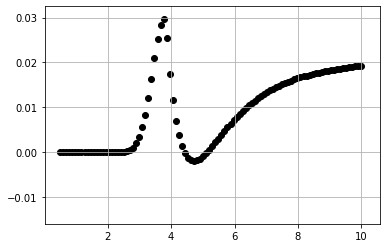

In [155]:
for i in range(100) :
    u=u_val[i]
    j = np.where(u_val >= u)[0][0]
    zm = singP[i]
    k = np.where(zm_val >= zm)[0][0]
    S = SS[k,j]
    F = FF[k,j]
    to = dzmdzm(z, z, Nu0, u)
    plt.scatter(u,to,c='black')
plt.grid()


In [312]:
zm_val = np.linspace(0,10,100)

/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/vasilis.dakos/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'S')

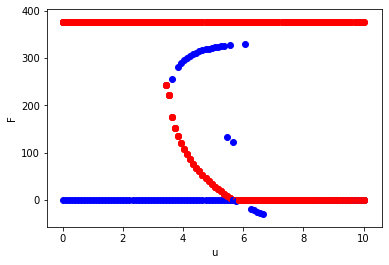

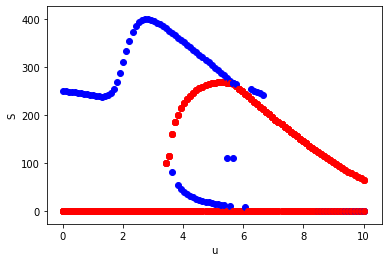

In [313]:
w=0.1
b=10
Nu0 = 50
u = 8
for i in range(100) : 
    z = zm_val[i]
    sol = op.fsolve(partial(F2, z = z,  u = u, Nu0 = Nu0), (3500,1000))
    sol2 = op.fsolve(partial(F2, z = z,   u = u, Nu0 = Nu0), (0,1500))
    sol3 = op.fsolve(partial(F2, z = z,   u = u, Nu0 = Nu0), (1500,1750))
    sol4 = op.fsolve(partial(F2, z = z,  u = u, Nu0 = Nu0), (0,500))
    sol5 = op.fsolve(partial(F2, z = z,   u = u, Nu0 = Nu0), (4000,0))
    sol6 = op.fsolve(partial(F2, z = z,   u = u, Nu0 = Nu0), (500,1500))
    sol7 = op.fsolve(partial(F2, z = z,  u = u, Nu0 = Nu0), (1000,1250))
    
    f_ = sol[1]
    f_1= sol2[1]
    f_2= sol3[1]
    f_3= sol4[1]
    f_4= sol5[1]
    f_5= sol6[1]
    f_6= sol7[1]
    s_ = sol[0]
    s_1= sol2[0]
    s_2= sol3[0]
    s_3= sol4[0]
    s_4= sol5[0]
    s_5= sol6[0]
    s_6= sol7[0]
    
    vp = np.linalg.eigvals(jacF2(z, s_,f_, Nu0, u))
    vp1 = np.linalg.eigvals(jacF2(z, s_1,f_1, Nu0, u))
    vp2 = np.linalg.eigvals(jacF2(z, s_2,f_2, Nu0, u))
    vp3 = np.linalg.eigvals(jacF2(z, s_3,f_3, Nu0, u))
    vp4 = np.linalg.eigvals(jacF2(z, s_4,f_4, Nu0, u))
    vp5 = np.linalg.eigvals(jacF2(z, s_5,f_5, Nu0, u))
    vp6 = np.linalg.eigvals(jacF2(z, s_6,f_6, Nu0, u))
    
    
    if np.all(vp < 0):
        plt.figure(1)
        plt.scatter(z, f_, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_, c = 'b')
    if np.all(vp1 < 0):
        plt.figure(1)
        plt.scatter(z, f_1, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_1, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_1, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_1, c = 'b')
    if np.all(vp2 < 0):
        plt.figure(1)
        plt.scatter(z, f_2, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_2, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_2, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_2, c = 'b')
    if np.all(vp3 < 0):
        plt.figure(1)
        plt.scatter(z, f_3, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_3, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_3, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_3, c = 'b')
    if np.all(vp4 < 0):
        plt.figure(1)
        plt.scatter(z, f_4, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_4, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_4, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_4, c = 'b')
    if np.all(vp5 < 0):
        plt.figure(1)
        plt.scatter(z, f_5, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_5, c = 'r')
    else: 
        plt.figure(1)
        plt.scatter(z, f_5, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_5, c = 'b')
    if np.all(vp6 < 0):
        plt.figure(1)
        plt.scatter(z, f_6, c = 'r')
        plt.figure(2)
        plt.scatter(z, s_6, c = 'r')
    else:
        plt.figure(1)
        plt.scatter(z, f_6, c = 'b')
        plt.figure(2)
        plt.scatter(z, s_6, c = 'b')
        
plt.figure(1)
plt.xlabel('u')
plt.ylabel('F')
plt.figure(2)
plt.xlabel('u')
plt.ylabel('S')